In [45]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

# Specify the path to the pickle file
# pickle_file = 'data/DATA_COXNET_DECEASED.pickle'

# # Load the data from the pickle file
# with open(pickle_file, 'rb') as f:
#     X, y = pickle.load(f)

In [48]:
pickle_file = 'data/DATA_DECEASED.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [49]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "RDR2",
    "DR53",
    "DR2",
    "COLD_ISCH_KI",
    "CREAT_DON",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


In [51]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
X = pipeline.fit_transform(dataset[numeric_features + categorical_features])
# print(dataset[numeric_features + categorical_features].columns)
survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

with open('pickle/trained_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [52]:
print(X)

[[-0.37242553 -1.23081067  1.62087538 ...  0.          0.
   1.        ]
 [-0.90628595  0.17159218 -1.09078927 ...  1.          0.
   0.        ]
 [-1.82147525  1.22339432 -1.09078927 ...  1.          0.
   0.        ]
 ...
 [ 1.38168728 -0.08674519  0.77724638 ...  0.          0.
   1.        ]
 [-1.28761483 -0.04983985  0.47595031 ...  1.          0.
   0.        ]
 [ 1.15288996  0.15313951  0.89776481 ...  1.          0.
   0.        ]]


In [53]:
from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from surv_data_pipeline.columns import COLUMNS
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)


In [63]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_
l1_ratios = [0.8]

In [64]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [65]:
from tqdm import tqdm
import numpy as np

best_params = None
highest_cindex=0

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox_grid=CoxnetSurvivalAnalysis()

pbar = tqdm(total = len(estimated_alphas)*len(l1_ratios), desc='Hyperparameter Tuning')

for ratio in l1_ratios:
    for alpha in estimated_alphas:
        cox_grid.set_params(l1_ratio=ratio, alphas=[alpha])

        cox_grid.fit(X_train, y_train)
        uno_score = evaluate_model_uno_c(cox_grid, X_test, y_test, y_train, times)

        uno = float(uno_score[0])
        if uno > highest_cindex:
            highest_cindex = uno
            best_params = (ratio, alpha)
            best_rsf_model = cox_grid

        # Update the progress bar
        pbar.update()

Hyperparameter Tuning: 100%|██████████| 100/100 [01:35<00:00,  1.01s/it]

In [71]:
highest_cindex

0.6888547220528997

In [67]:
best_params

(0.8, 0.0027421014675726627)

In [68]:
coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=best_params[0],alphas=[best_params[1]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alphas=[0.0027421014675726627], fit_baseline_model=True,
                       l1_ratio=0.8)

In [69]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

evaluate_model_uno_c(coxnet_pred, X_test, y_test, y_train, times)

(0.6888547220528997, 101953875, 46427743, 0, 22418)

In [70]:
import pickle

with open('pickle/COXNET_DECEASED_MODEL.pickle', 'wb') as f:
    pickle.dump(coxnet_pred, f)

In [75]:
prediction = coxnet_pred.predict_survival_function(X_test)

In [76]:
prediction.shape

(23514,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


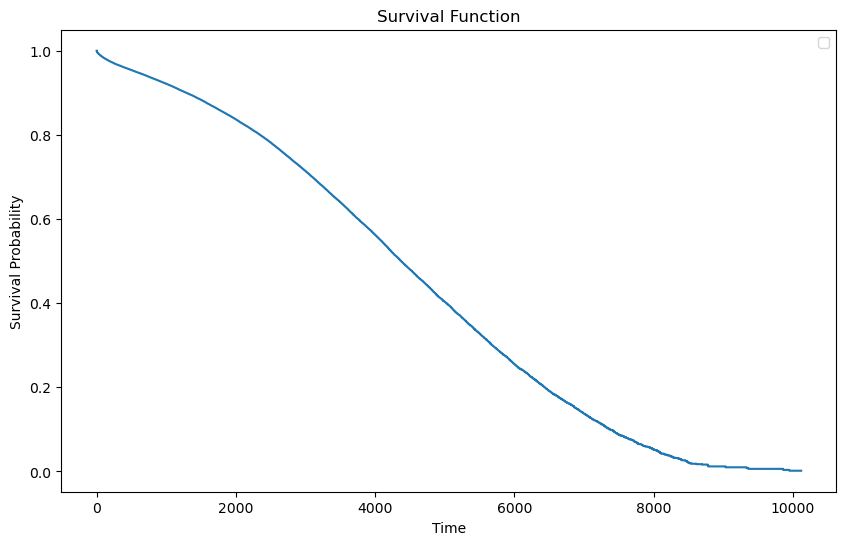

In [88]:
import matplotlib.pyplot as plt

patient_id = 90

plt.figure(figsize=(10, 6))
plt.step(prediction[patient_id].x, prediction[patient_id].y)

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Function")
plt.legend()
plt.show()

In [85]:
from sklearn.inspection import permutation_importance


result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=1)

In [ ]:
columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

In [89]:
dataset.head()

,GENDER,ON_DIALYSIS,DR53,NPKID,COLD_ISCH_KI,BMI_CALC,DIABETES_DON,AGE_DON,DR2,PTIME,ETHCAT,PSTATUS,PRE_TX_TXFUS,CREAT_TRR,DIAB,AGE,RDR2,HCV_SEROSTATUS,CREAT_DON
__null_dask_index__,,,,,,,,,,,,,,,,,,,
191,M,N,0.0,0.0,20.4,21.1,N,65.0,13.0,3501.0,4,1.0,N,10.7,5.0,47.0,103.0,P,1.2
1891,M,N,0.0,0.0,25.0,28.7,N,20.0,0.0,6479.0,2,1.0,Y,22.2,1.0,40.0,97.0,N,1.0
2420,M,N,0.0,1.0,16.0,34.4,N,20.0,11.0,5460.0,2,0.0,N,23.6,1.0,28.0,11.0,N,1.0
3705,F,N,0.0,0.0,20.0,35.7,N,39.0,10.0,6008.0,1,1.0,Y,11.8,5.0,42.0,10.0,N,0.8
4702,F,N,0.0,0.0,21.3,21.9,N,44.0,14.0,5277.0,4,0.0,N,5.5,1.0,42.0,14.0,N,2.6


In [90]:
dataset["CREAT_TRR"].describe()

count    117568.000000
mean          8.251785
std           3.508183
min           0.100000
25%           5.700000
50%           7.820000
75%          10.300000
max          28.200000
Name: CREAT_TRR, dtype: float64

In [92]:
dataset["CREAT_DON"].describe()

count    117568.000000
mean          1.121843
std           0.944601
min           0.100000
25%           0.700000
50%           0.960000
75%           1.300000
max          25.000000
Name: CREAT_DON, dtype: float64

In [93]:
dataset["COLD_ISCH_KI"].describe()

count    117568.000000
mean         18.016163
std           8.981343
min           0.000000
25%          11.870000
50%          17.000000
75%          23.000000
max          99.000000
Name: COLD_ISCH_KI, dtype: float64